第６章　****複雑な時系列のモデル化****

第４章では移動平均プロセス、第５章では自己回帰プロセスを取り上げました。

この章ではACFプロットまたはPACFプロットから字数を推測できない時系列に対処する方法を学びます。

本章では自己回帰移動平均プロセスARMA(p,q)を調べます。

6.1 データセンターの帯域幅使用量を予測する


帯域幅はデータ転送の最大速度と定義され、基本単位はビット毎秒(bps)

2019年1月1日から一時間ごとの帯域幅使用量を表すデータの時系列を可視化すると図の6.1になります。

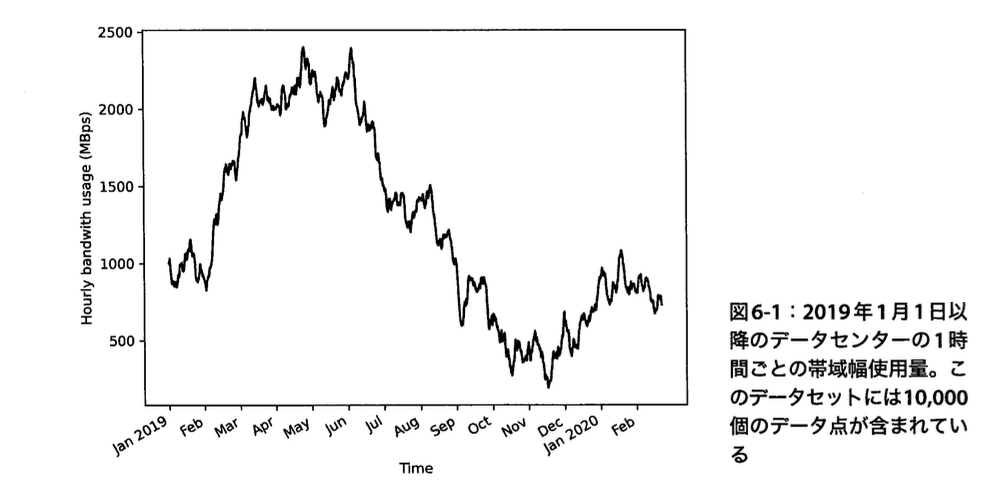

図6.1から長期的なトレンドの存在が見れるため、定常でない可能性が高いので変換を適用する必要があります。

また、周期的な変動が無いので季節性の影響を除外できます。

帯域幅使用量を予測するるには、この時系列のプロセスを特定する必要があるので、前章で定義した手順に従います。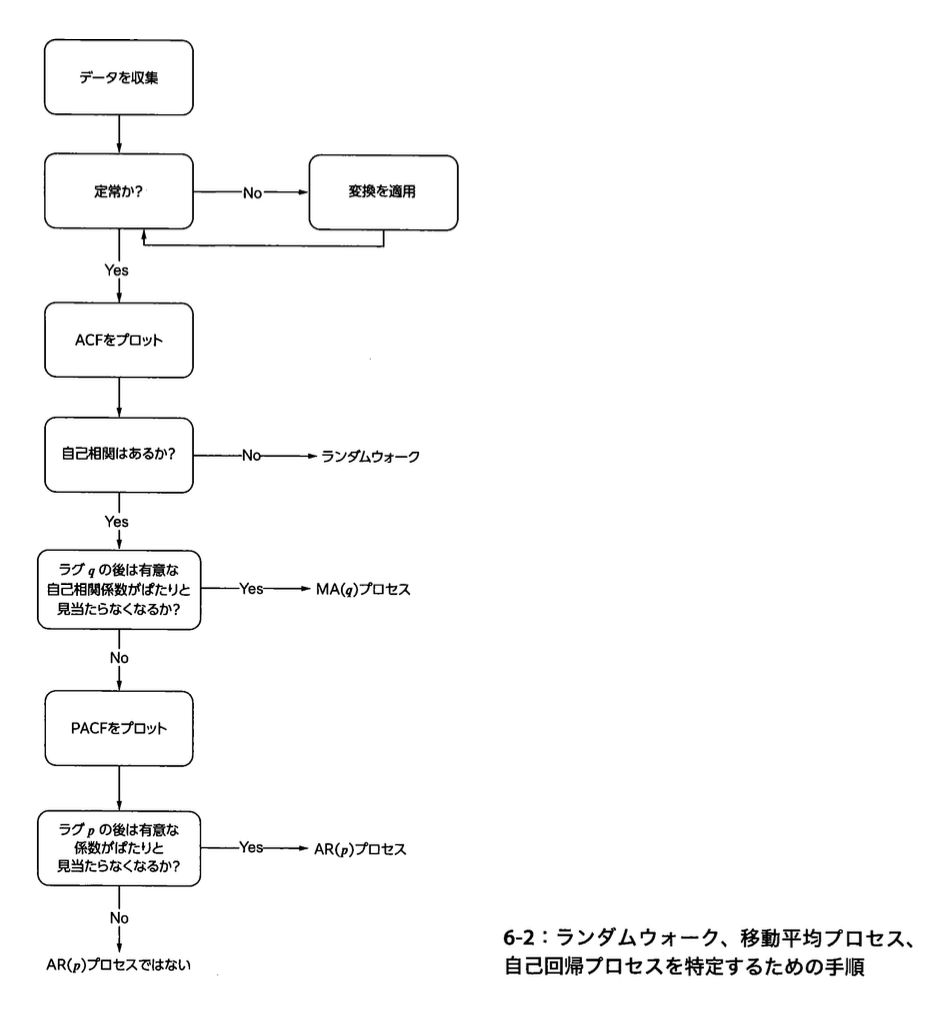

# ARMAモデルとは？

# ARMA(p, q) プロセス

ARMA（AutoRegressive Moving Average）モデルは、自己回帰（AR）成分と移動平均（MA）成分を組み合わせ、**過去の値（AR）**と**誤差の履歴（MA）**を使って、
現在の値を予測するモデル**時系列モデル**です。

## 数式

ARMA(p, q)モデルは以下のように表されます：

$$
Y_t = C+\phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + μ+\varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q}
$$



## 短く表すと：

$$
Y_t = \sum_{i=1}^{p} \phi_i Y_{t-i} + μ+\varepsilon_t + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j}
$$



6.2自己回帰移動平均プロセス（ARMA）プロセスを調べる

## ARMA(1,1) モデルの例

次数１のAR(1)プロセスと次数１のMA(1)プロセスの組み合わせになります。

$$
AR(1) := y_t = C + \phi_1 y_{t-1} + \varepsilon_t
$$
$$
MA(1) := y_t = \mu + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$


$$
ARMA(1,1) := y_t = C + \phi_1 y_{t-1} + μ+ \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$



##  ARMA(2,1) モデル

ARMA(2,1)モデルは、自己回帰（AR）成分2つと移動平均（MA）成分1つを含むモデルです。


$$
AR(2) := y_t = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t
$$

$$
ARMA(2,1) := y_t = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$


6.3　定常的なARMAプロセスを特定する

先ほど自己回帰移動平均プロセスを定義して、次数p、qがモデル式にどのような影響を与えるのかを確認しました。

次は、特定の時系列でそうしたプロセスを識別する方法を突き止める必要があります。

ここではARMA(1,1)プロセスをシュミレートします。

定数Cと平均μはどちらも０に等しいものとします。係数0.33と0.9は主観的に設定したものです。

$$
y_t = 0.33y_{t-1} + 0.9\varepsilon_{t-1} + \varepsilon_t
$$

このシュミレーションの目標はACFプロットとPACFプロットではARMAプロセスの次数p、qが特定できないことを実証することです。

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

ar1 = np.array([1, -0.33])

ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

次にこのプロセスが定常かどうかを検証するためにADF検定を実行しADFμ統計量とp値を出力します。


In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042687
p-value: 1.707846668009726e-08


次にACFプロットをしシュミレートしたARMA（1、1）プロセスの移動平均部分の字数を推定できるか確認します。

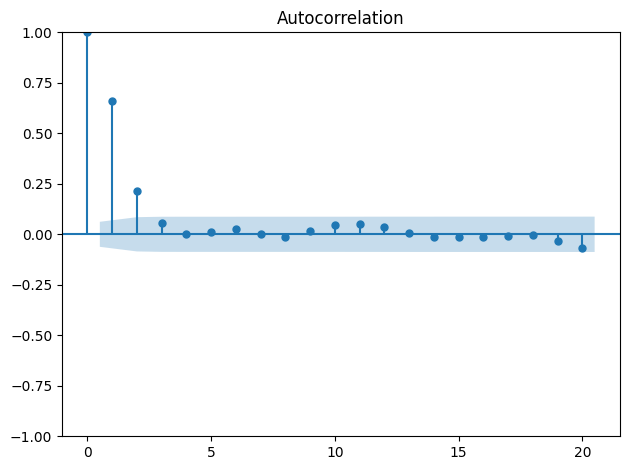

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ARMA_1_1, lags=20)
plt.tight_layout()

シュミレートしたARMA（1,1）プロセスのACFプロットの最後の優位な係数はラグ2になるためq=1。シュミレートしたARMA（1,1）プロセスなのでq=1。

したがってARMA（1,1）プロセスの次数qの推定にはACFプロットを使うことができない。

次にPACFプロットをしシュミレートしたARMA（1、1）プロセスの字数を特定できるかを確認します。

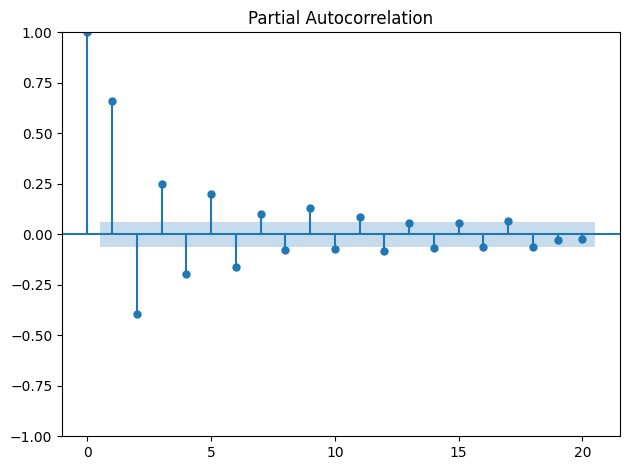

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

これは明らかに正弦波パターンを示しています。つまり次数pの値を推定することができません。

ACFプロットもPACFプロットでも有意な係数とそうで無い係数の境界がはっきりしないためこのプロセスはARMA（p,q）プロセスであると結論づけられます。

6.4　一般的なモデル化手続きを考え出す

ACFプロットとPACFプロットの両方で正弦波パターンまたは減衰パターンが見られる場合は、時系列をARMA(p,q)プロセスでモデル化できる。

しかし、どちらのプロットも次数p,qの特定には役立ちませんでした。

このため次数p,qを特定するための手続きを考えます。

この手続きは時系列が定常ではなく、季節的な影響がある状況でも適用でき、pまたはが0に等しいケースでも適用できます。

つまりモデル選択の基準と残渣分析だけを頼りにpとqを求められます。

この手続きは図6-6のようになります。

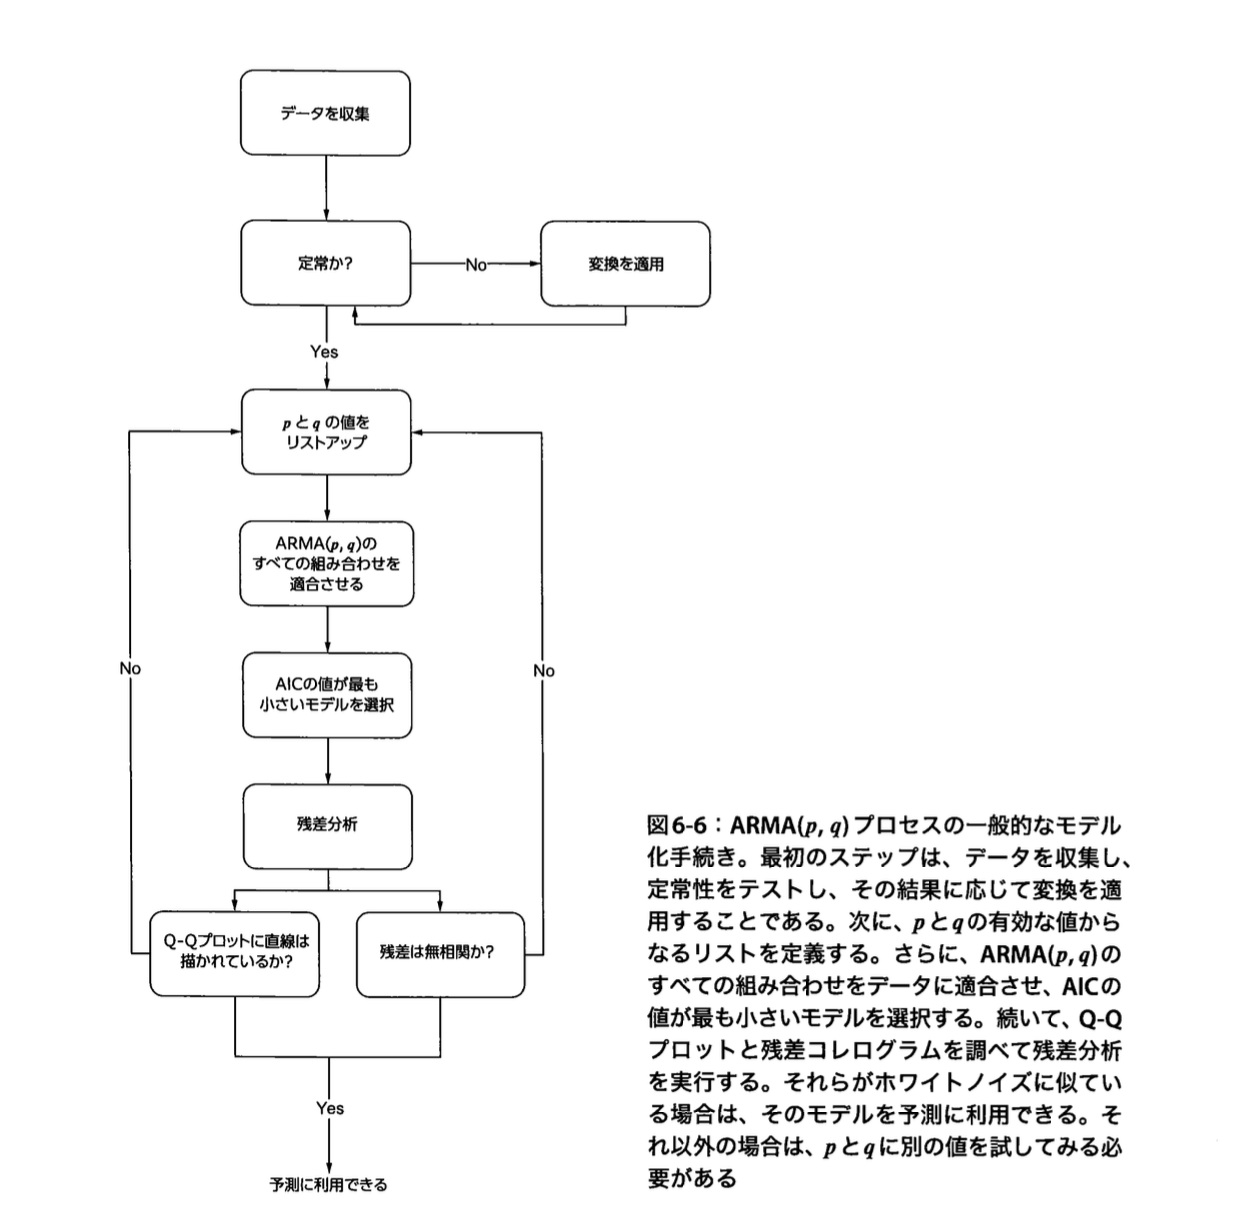

この場合も、データを収集し、定常性をテストして、その結果に応じて変換を適用します。そしてp,qの有効な値と思われるものをリストアップしARMA(p,q)の組み合わせをデータに適合させます

その次に赤池情報基準（AIC）を計算します。
そしてその中からAICの値が最も小さいモデルを選択します。

そこからモデルの実測値と予測値であるモデルの残差の分析ををし、Q-Qプロット、リュングボックス検定を用いてG-Gプロットは直線であるかと無相関であるかを調べます。

分析の結果、完全にランダムと言えれば、そのモデルを使って予測をできるが、それ以外はp,qに別の値を探して最初からやり直す必要があります。

6.4.1　赤池情報基準(AIC)

統計モデルを選ぶときに「どのモデルがもっとも良いか」を判断するための指標です。

AICは推定されたパラメータの個数kとモデルのワイド関数の最大値Lの関数
$$
AIC = 2k - 2ln(\hat L)
$$

ここでkはパラメータの個数でp+qで表されます。次数(p,q)の値が大きくなるほどパラメータの数が増えAICの値が大きくなる。

$ln(\hat L)$ は観測されたデータがどれくらいARMAモデルから得られる可能性があるのかを表している。

つまり$(\hat L)$の値が大きいほどAICの値は小さくなる。




ここではシュミレートしたARMA（1,1）を使ってモデルをステップごとに見ていきます。

すでにシュミレートしているプロセスが定常だとわっかているので、p,qの有効な値をリストアップできます。

ここではp,qの値を0~3にしますがこの範囲には特に根拠がありません。必要であればもっと広い範囲の値を試しても構いません。


In [ ]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.162939
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


この場合、データに適合させた他のすべてのモデルとの相対では、ARMA(1,1)が最も良いモデルであると言える。

6.4.3 残差分析

ここではQ-Qプロットに直線が描かれているのか、残差は無相関であるのかについて調べます。

モデルの残差は単に予測値と実測値の差です。

シュミレートしているARMA(1,1)について考えてみましょう。

$$
y_t = 0.33y_{t-1} + 0.9\varepsilon_{t-1} + \varepsilon_t
$$



このプロセスにARMA(1,1)モデルを適合させたところ、モデルの係数が完璧に推定され、モデル式が以下のように表されたとします。
$$
\hat y = 0.33y_{t-1} + 0.9\varepsilon_{t-1}
$$

残差はこのモデルから得られる値と、シュミレートしたプロセスで観測された値との差です。
$$
residuals = 0.33y_{t-1} + 0.9\varepsilon_{t-1} + \varepsilon_t - (0.33y_{t-1} + 0.9\varepsilon_{t-1})
$$
$$
residuals = \varepsilon_t
$$
完璧な状態ではモデルの残差はホワイトノイズになります。

これは予測に役立つ情報モデルがすべて捕捉していて、残っているのがモデル化できないランダムな変数だけであることを示しています。

次に定性分析と定量分析をします。

定性分析ではQ-Qプロットの調査に焦点を合わせるのに対し、定常分析では残差が無相関可動かを判断します。

**定性分析:Q-Qプロットについて調べる**

残差分析の最初のステップではQ-Qプロットを調べます。

Q-Qプロットとは得られたデータと理論分布（この場合は正規分布）を比較し、その類似度を調べるためのグラフです。

両方の分布が似ている場合、つまり残差の分布が正規分のに近い場合y=xとほぼ重なる直線となる。

これに対して残差の分布が正規分布と異なる場合は曲線が描かれます。



定量分析:**リュング・ボックス検定**

リュングボックス検定とはある時系列の自己相関があるかどうかを検証する統計学的検定。

帰無仮説は「データの分布が独立していて、自己相関がない」です。

p値が0.05より大きい場合、帰無仮説は棄却されません。つまり、残差は独立しいて、自己相関がないということになります。

**6.4.4 残差分析を行う**

残差分析を実行するのに、モデルを適合させ、残差を変数に格納して簡単にアクセスできるようにします。

In [ ]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)

residuals = model_fit.resid

それではQ-Qプロットを生成します。

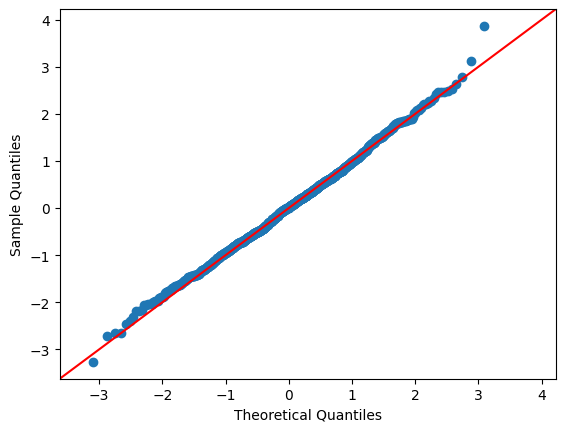

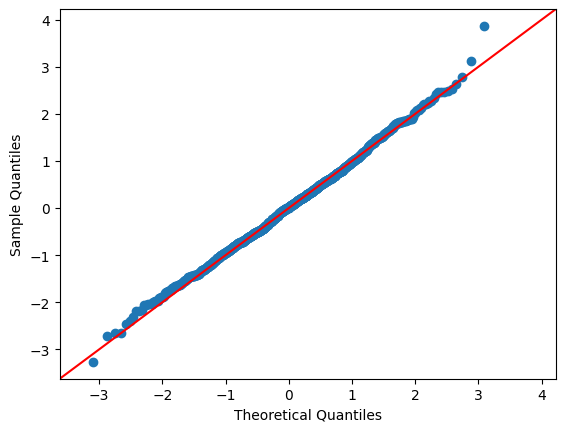

In [ ]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

次のステップはリュング・ボックス検定です。


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))
result_df

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093
